## Setup and Data Import

In [1]:
import numpy as np

import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_columns = None

import sys
sys.path.insert(0,'..')

import Imputation_Module as imp # imports csv files
import FeatureEngineering_Module as fe
import Encoding_Module as ec

from sklearn.metrics import mean_squared_error
import sklearn.linear_model as lm
import sklearn.model_selection as ms
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm

import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

## Imputation and Feature Engineering

In [2]:
train, test = imp.impute_data()

train = fe.FeatureEngineering(train)
test = fe.FeatureEngineering(test)

train_dummies, test_dummies = fe.Dummify(train, test)

train_ec, test_ec = ec.encode(train, test)

In [3]:
X = train_dummies.drop('SalePrice', 1)
y = train_dummies.SalePrice

In [4]:
X_ec = train_ec.drop('SalePrice', 1)
y_ec = train_dummies.SalePrice

## Modeling

### Linear Modeling with Log(y)

In [5]:
X_train, X_test, y_train, y_test \
    = ms.train_test_split(X, np.log(y), test_size=0.2, random_state=0)

In [29]:
def linear_model(model, X=X_train, y=y_train):
    if type(model).__name__ == "LinearRegression()":
        score = np.mean(ms.cross_val_score(ols, X, y, cv=10))
        y_pred = ms.cross_val_predict(ols, X, y, cv=10)
    else:
        model.fit(X, y)
        score = model.score(X, y)
        y_pred = model.predict(X)

    RMSLE = mean_squared_error(y, y_pred, squared=False)
    print('%s R^2: %0.5f'
          % (type(model).__name__, score.mean()))
    print('Root Mean Squared Error: %0.5f' % RMSLE)

#### Baseline

In [30]:
ols = lm.LinearRegression(normalize=True)
linear_model(ols)

LinearRegression R^2: 0.93175
Root Mean Squared Error: 0.10385


#### Ridge

In [31]:
ridgecv = lm.RidgeCV(alphas=np.logspace(-5, 5, 100), normalize=True)
linear_model(ridgecv)


RidgeCV R^2: 0.93012
Root Mean Squared Error: 0.10509


#### Lasso

In [9]:
lasso = lm.LassoCV(normalize=True)
linear_model(lasso)

LassoCV R^2: 0.92876
Root Mean Squared Error: 0.10611


#### Elastic Net

In [10]:
net = lm.ElasticNetCV(normalize=True)
linear_model(net)

ElasticNetCV R^2: 0.92918
Root Mean Squared Error: 0.10579


In [32]:
ols_coefs = pd.DataFrame({'feature': np.array(X_train.columns),
                            'coefficient': ols.coef_}
                          ).sort_values('coefficient', ascending=False)

# ols_coefs.plot.barh(y='coefficient', x='feature', figsize=(12, 40),
#                       title='RidgeCV Coefficients');

In [49]:
X_add_const = sm.add_constant(X_train)
sm_ols = pd.DataFrame(sm.OLS(y_train, X_add_const).fit().summary().tables[1])
sm_ols.rename(columns=sm_ols[0]).drop(sm_ols.index[0])

,,const,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_Reg
1,const,9.1233,0.162,56.234,0.000,8.805,9.442
2,MSZoning_FV,0.4329,0.060,7.237,0.000,0.316,0.550
3,MSZoning_RH,0.4444,0.062,7.130,0.000,0.322,0.567
4,MSZoning_RL,0.4373,0.050,8.724,0.000,0.339,0.536
5,MSZoning_RM,0.3837,0.046,8.351,0.000,0.294,0.474
6,LotShape_Reg,-0.0019,0.009,-0.213,0.831,-0.019,0.015
7,LandContour_NotLvl,0.0016,0.014,0.114,0.909,-0.027,0.030
8,LotConfig_CulDSac,0.0365,0.018,2.059,0.040,0.002,0.071
9,LotConfig_FR,-0.0343,0.021,-1.618,0.106,-0.076,0.007
10,LotConfig_Inside,-0.0066,0.010,-0.675,0.500,-0.026,0.012


### Tree Modeling

In [15]:
Xec_train, Xec_test, yec_train, yec_test = ms.train_test_split(X_ec, y_ec, test_size=0.2, random_state=0)

In [16]:
def get_error(model, X_train=Xec_train, y_train=yec_train, X_test=Xec_test, y_test=yec_test):
    model.fit(X_train, y_train)
    train_error = 1 - model.score(X_train, y_train)
    test_error  = 1 - model.score(X_test, y_test)
    print("The training error is: %.5f" %train_error)
    print("The test error is: %.5f" %test_error)

#### Baseline (Log(y))

In [17]:
tree_model = tree.DecisionTreeRegressor()
get_error(tree_model)

The training error is: 0.00000
The test error is: 0.21693


In [18]:
grid_para_tree = {'criterion': ["mse", "friedman_mse", "mae"],
                  'max_depth': range(1, 12)}
grid_search_tree = ms.GridSearchCV(tree_model, grid_para_tree, cv=10)

get_error(grid_search_tree)
print('The best score is %.4f' %grid_search_tree.best_score_)
print('The best parameters are %s' %grid_search_tree.best_params_)

The training error is: 0.10240
The test error is: 0.22758
The best score is 0.7275
The best parameters are {'criterion': 'friedman_mse', 'max_depth': 6}


#### Gradient Boosting

In [19]:
# gb_model = GradientBoostingRegressor()

# grid_para_gb = {'loss': ['ls', 'lad', 'huber', 'quantile'],
#                 'criterion': ["mse", "friedman_mse", "mae"],
#                 'max_depth': range(1, 12)}
# grid_search_gb = ms.GridSearchCV(gb_model, grid_para_gb, cv=10)

# get_error(grid_search_gb)

# # -------------------------------------------------------------
# # TAKES FOREVER TO RUN. RESULTS:

# # The best parameters are: {'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 4}

In [20]:
gb_model = GradientBoostingRegressor(loss='huber', max_depth=4)
get_error(gb_model)

The training error is: 0.02655
The test error is: 0.08409


##### Feature Importances

In [22]:
feat_imp = pd.DataFrame({'feature': np.array(Xec_train.columns),
                         'importance': gb_model.feature_importances_})

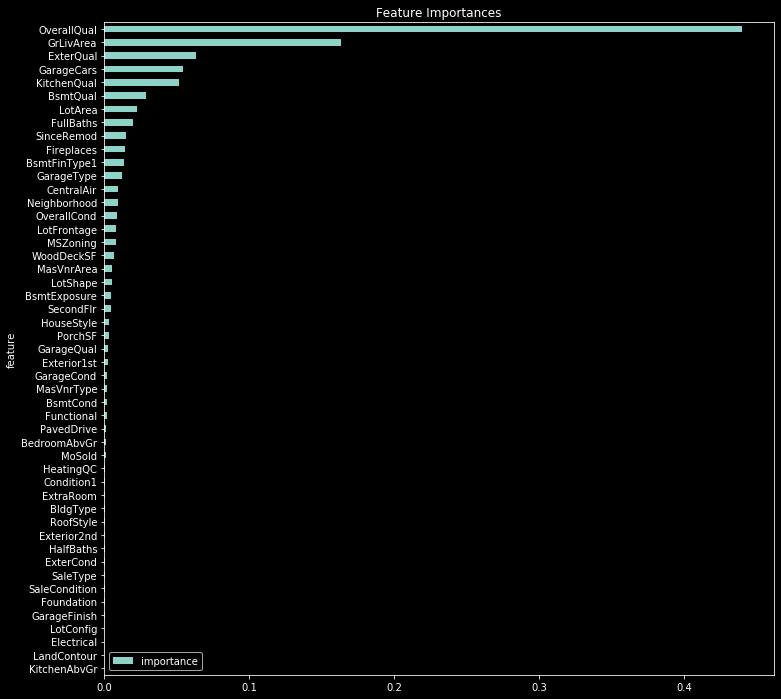

In [23]:
feat_imp.sort_values('importance').plot.barh(y='importance', x='feature', figsize=(12,12),
                   title='Feature Importances');

- OverallQual: Rates the overall material and finish of the house
- GrLivArea: Above grade (ground) living area square feet
- ExterQual: Evaluates the quality of the material on the exterior 
- GarageCars: Size of garage in car capacity
- KitchenQual: Kitchen quality